In [122]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima import model_selection
import statsmodels
from pmdarima.pipeline import Pipeline
from pmdarima import preprocessing
from pmdarima import arima
import glob

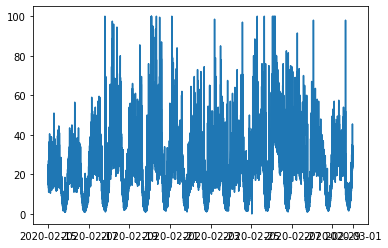

                     CpuUtilizationAverage
TimeStampUtc                              
2020-02-15 00:00:00                   19.0
2020-02-15 00:01:00                   18.0
2020-02-15 00:02:00                   20.0
2020-02-15 00:03:00                   16.5
2020-02-15 00:04:00                   25.0
...                                    ...
2020-02-29 23:55:00                   28.5
2020-02-29 23:56:00                   33.0
2020-02-29 23:57:00                   34.5
2020-02-29 23:58:00                   24.0
2020-02-29 23:59:00                   31.0

[21600 rows x 1 columns]


In [35]:
# Loads raw dataset
dataset = 'WI'
data = pd.read_csv('samples/' + dataset + '.csv', delimiter=',', index_col=0, parse_dates=True)

plt.plot(data)
plt.show()
print(data)


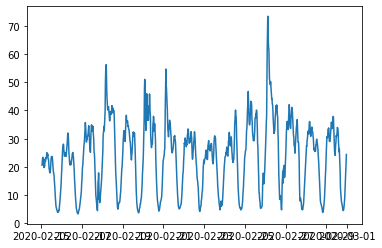

((360, 1), (1077, 1))

In [100]:
# Helper to downsample data to a frequency (in minutes)
freq = 60
downsampled = data.resample(str(freq) + 'T').mean()
seasonality = (24 * 60) // freq
split = 0.8

# Split into train and test datasets
raw_values = np.asarray(downsampled['CpuUtilizationAverage'])
tsize = math.floor(raw_values.shape[0] * split)
train, test = model_selection.train_test_split(raw_values, train_size=tsize)
seasonality
plt.show()
downsampled.shape


0 0


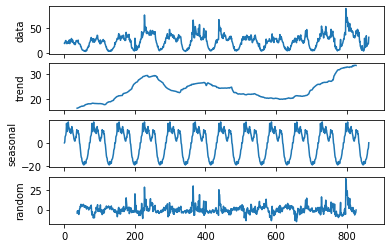

<Figure size 432x288 with 0 Axes>

In [97]:
# Finds differencing and seasonal differencing components
diff = pm.arima.ndiffs(train, max_d=5)

seasonal_diff = pm.arima.nsdiffs(train, seasonality, max_D=5)
print(diff, seasonal_diff)

#Decomposes data into seasonal, trend, and random
decomposed_tuple = pm.arima.decompose(train, 'additive', seasonality)
pm.utils.visualization.decomposed_plot(decomposed_tuple , figure_kwargs={})


In [106]:
mean = train.mean()
mean_forecasts = np.ones(test.shape[0]) * mean
naive_forecasts = np.ones(test.shape[0]) * train[-1]
naive_sliding = np.array([raw_values[train.shape[0] + i - 1] for i in range(test.shape[0])])

In [101]:
# Trains model on a single dataset, using Auto ARIMA to find hyper parameters
from datetime import datetime

start = datetime.now()
p, d, q= (1,0,1)
P, D, Q = (3, 0, 3)
model = pm.auto_arima(train, seasonal=True, m=seasonality, d=diff, D=seasonal_diff, suppress_warnings=False, start_p=2, start_q=2, max_Q=3, max_P=3, max_p=3, max_d=3, order=5)
res = model.fit(train)
end = datetime.now()
print("Trained in " + str(end - start))
forecasts = model.predict(test.shape[0])
model.summary()


/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Trained in 0:02:04.451637


In [103]:
# Utility to save dataset. Just call pickle.load to reload
import pickle
filename = f"./arima_models/{dataset}_{freq}M_(1_0_1)_(3_0_3)_{train_frac}"
pickle.dump(model, open( filename, "wb" ))


Does cross validation using a sliding window. Currently, is not performant enough to be useful. 

In [78]:
# assumes we have a model, model
from datetime import datetime

# Window size of n_samples/5, one step, one forecast horizon
start = datetime.now()
cv = model_selection.SlidingWindowForecastCV(step=30, h=30, window_size=20)
sliding_forecasts = model_selection.cross_val_predict(model, raw_values)
end = datetime.now()

sliding_forecasts

/home/rayan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


KeyboardInterrupt: 